# Annual School Demand Profile for Kennington 

This is creating an average annual school demand profile for one school in Kennington. It will have 48*365 data points each of which is the half hourly power.

I have encorporated seasonal variation into this model.

**Author:** Minnie Karanjavala

**Date:** Janurary 23rd, 2021

**College:** St Peter's

## How it Differs from Previous Version:
- in Non_Dom_elec_annual_profile_1 I was using some old figures for the total non-dom electricity usage and i was just figuring out how to make the profiles so there is a lot of testing and it's heavily commented
- in Non_Dom_elec_annual_profile_2 I was using the updated figures for non-dom electricity usage (but still not the most up to date figures i don't think) - they still included schools in the electricity usage
- in Non_Dom_elec_annual_profile_3 I removed the electricity demand for schools from the total value I was using so that it is more accurate as i am making a seperate school profile which doesn't include holidays or weekends 
- in this file I have made some nice looking plots for my report

## Goal:
- to produce a annual non-domestic demand profile for average user for current electricity consumption in Kennington (not incl electrification of gas)

- find a scale factor which scales the average UK demand profile to match Kennington's annual usage

- OUTPUT = I want to produce a csv file which has 365*48 data points which is the non-domestic electricity demand profile for the year


### NOTE: I am combinging the daily elexon demand profiles for weekdays and weekends across the seasons to form an accurate annual demand profile for the average user in Kennington.

## Plan:
- figure out how many weeks for each season 
- string together the various daily profiles of each season (weekday + weekend) to form an annual UK non-dom demand profile for average user 
- scale this annual UK demand per user (using scale factor) to match Kennington's demand per user
- export the scaled profile in a CSV file 
- plot it to check what it looks like - both daily and annual profiles

In [166]:
# importing the modules
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pickle
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import statistics

In [167]:
# read csv into a dataframe
non_dom_load_df = pd.read_csv('../../data/ProfileClass3.csv')  
non_dom_load_df['Time'] = pd.to_datetime(non_dom_load_df['Time'])
#non_dom_load_df.info()

In [168]:
### ADD A COLUMN OF ZEROS TO DATAFRAME 

zeros = np.zeros(48)
#print(zeros)

non_dom_load_df['Zero'] = zeros
print(non_dom_load_df.info())
#print(non_dom_load_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Time     48 non-null     datetime64[ns]
 1   Aut Wd   48 non-null     float64       
 2   Aut Sat  48 non-null     float64       
 3   Aut Sun  48 non-null     float64       
 4   Hsr Wd   48 non-null     float64       
 5   Hsr Sat  48 non-null     float64       
 6   Hsr Sun  48 non-null     float64       
 7   Smr Wd   48 non-null     float64       
 8   Smr Sat  48 non-null     float64       
 9   Smr Sun  48 non-null     float64       
 10  Spr Wd   48 non-null     float64       
 11  Spr Sat  48 non-null     float64       
 12  Spr Sun  48 non-null     float64       
 13  Wtr Wd   48 non-null     float64       
 14  Wtr Sat  48 non-null     float64       
 15  Wtr Sun  48 non-null     float64       
 16  Zero     48 non-null     float64       
dtypes: datetime64[ns](1), float64(16)
mem

Create a 'seasons' array which contains 365 elements - specifying whether each day of the year is a weekday or sat or sun and which season it is 

In [169]:
# make an array for each season - representing one week in that season
# Wtr = ['Wtr Wd' 'Wtr Wd' 'Wtr Wd' 'Wtr Wd' 'Wtr Wd' 'Wtr Sat' 'Wtr Sun']
# Spr = ['Spr Wd' 'Spr Wd' 'Spr Wd' 'Spr Wd' 'Spr Wd' 'Spr Sat' 'Spr Sun']
# Smr = ['Smr Wd' 'Smr Wd' 'Smr Wd' 'Smr Wd' 'Smr Wd' 'Smr Sat' 'Smr Sun']
# Hsr = ['Hsr Wd' 'Hsr Wd' 'Hsr Wd' 'Hsr Wd' 'Hsr Wd' 'Hsr Sat' 'Hsr Sun']
# Aut = ['Aut Wd' 'Aut Wd' 'Aut Wd' 'Aut Wd' 'Aut Wd' 'Aut Sat' 'Aut Sun']

Wtr = np.array(['Wtr Wd', 'Wtr Wd', 'Wtr Wd', 'Wtr Wd', 'Wtr Wd', 'Zero', 'Zero'])
Spr = np.array(['Spr Wd', 'Spr Wd', 'Spr Wd', 'Spr Wd', 'Spr Wd', 'Zero', 'Zero'])
Smr = np.array(['Smr Wd', 'Smr Wd', 'Smr Wd', 'Smr Wd', 'Smr Wd', 'Zero', 'Zero'])
Hsr = np.array(['Hsr Wd', 'Hsr Wd', 'Hsr Wd', 'Hsr Wd', 'Hsr Wd', 'Zero', 'Zero'])
Aut = np.array(['Aut Wd', 'Aut Wd', 'Aut Wd', 'Aut Wd', 'Aut Wd', 'Zero', 'Zero'])
Holiday = np.array(['Zero', 'Zero', 'Zero', 'Zero', 'Zero', 'Zero', 'Zero'])


print(Wtr)
type(Wtr)

['Wtr Wd' 'Wtr Wd' 'Wtr Wd' 'Wtr Wd' 'Wtr Wd' 'Zero' 'Zero']


numpy.ndarray

### How Many Weeks each Elexon season lasts

- winter = 22 weeks 
- spring = 6 weeks 
- summer = 10 weeks 
- high summer = 6 Weeks
- autumn = 8 weeks 

Calculated from the info given in Elexon document about the load profiles.

In [170]:
# add the correct number of weeks worth of each season to the 'seasons' array to make up a year (ie 52 wks = 365 days) using the weeks given above
seasons = np.array([])  # define an empty array 


for i in range(1):
    seasons = np.append(seasons,Holiday)    # autumn half term

for i in range(7):
    seasons = np.append(seasons,Wtr) 

for i in range(3):
    seasons = np.append(seasons,Holiday)    # xmas vac

for i in range(5):
    seasons = np.append(seasons,Wtr) 

for i in range(1):
    seasons = np.append(seasons,Holiday)    # spring half term

for i in range(5):
    seasons = np.append(seasons,Wtr) 

###### END OF WINTER SEASON

for i in range(2):
    seasons = np.append(seasons,Holiday)    # easter vac

for i in range(4):
    seasons = np.append(seasons,Spr) 

###### END OF SPRING SEASON

for i in range(3):
    seasons = np.append(seasons,Smr) 

for i in range(1):
    seasons = np.append(seasons,Holiday)    # summer half term

for i in range(6):
    seasons = np.append(seasons,Smr) 

###### END OF SPRING SEASON

for i in range(6):
    seasons = np.append(seasons,Holiday) 

for i in range(8):
    seasons = np.append(seasons,Aut)

seasons = np.append(seasons,'Aut Wd')   # I add this as 52wks*7days = 364 days so I need to add one more day to make it up to 365

#print(seasons)
seasons.size

365

In [171]:
# create an array which contains 48*365 data points ~ half hourly power (kW) for an average non-domestic user in the UK ~ call this UK_annual_demand 
UK_annual_demand = np.array([])        # define empty array - this will contain the average non dom demand profile of a UK user

for day in seasons:
    UK_annual_demand = np.append(UK_annual_demand,non_dom_load_df[day].values)   # kW

print(UK_annual_demand.size)

17520


## Find scale factor for Kennington 

Find the scale factor which will scale the average demand of UK non dom user to the average demand of a kennington non-dom user

In [172]:
ken_annual_nd_usage = 220000   #kWh ~ this is for all the non-domestic users in Kennington NOT including the schools/nurseries 

ken_nd_users = 2   # number of schools in Kennington ~ there are 4 businesses in the education category, 2 reasonably sized primary schools and two tiny nurseries who's consumption is about 2% of the overall consumption ~ so in order for the demand profile to accurately reflect the demand of a school i am classing there are being 2 schools not 4 for the given annual consumption figures 

ken_avg_annual_usage_per_nd_user = ken_annual_nd_usage/ken_nd_users # kWh - avg annual energy (kWh) useage PER SCHOOL in kennington  

UK_avg_anuual_usage_per_nd_user = np.sum(UK_annual_demand)*0.5 # the UK_annual_demand array is POWER for every 0.5hr so we need to CONVERT it from kW to kWh by *0.5hr

print(UK_avg_anuual_usage_per_nd_user)
print(ken_avg_annual_usage_per_nd_user)

8110.985000000001
110000.0


In [173]:
print(UK_annual_demand)

[0.   0.   0.   ... 0.78 0.74 0.69]


In [174]:
# SF = scale factor 
SF = ken_avg_annual_usage_per_nd_user/UK_avg_anuual_usage_per_nd_user 
ken_avg_nd_load_profile = UK_annual_demand*SF 

# just printing a few things to sanity check my figures
print(SF)

# print(ken_avg_nd_load_profile.size)
# print(np.sum(ken_avg_nd_load_profile)) 
# print(ken_avg_nd_load_profile)
print(ken_avg_nd_load_profile)

13.561854694590114
[ 0.          0.          0.         ... 10.57824666 10.03577247
  9.35767974]


## Correct order of data - to make day 1 = 1st Jan

How I formed my demand dataset meant that the first 22 weeks of the dataset are for winter data so the day 1 demand profile isn't for 1st Jan it's for 25th Oct. I needed to fix this by taking the data 25th Oct -31st Dec and adding it onto the end of the data set which was days 1st Jan-24th Oct.

The first 9 weeks and 4 days make up (25th Oct - 31st Dec) then the rest is 1st Jan-24th Oct 

In [175]:

print(ken_avg_nd_load_profile.size)

# this extracts the data points for days 25 Oct-31st Dec
end_of_year = ken_avg_nd_load_profile[0:48*(9*7+4)]     # we know that dec 31st is 9 weeks and 4 days after the start of dataset. This is half hourly data so 48 data points in each day therefore the num of datapoints in the first 9 weeks and 4 days = 48*(9*7+4)

# this captures the data points for days 1st Jan-25th Oct 
start_of_year = ken_avg_nd_load_profile[48*(9*7+4):]

corrected_ken_avg_nd_load_profile = np.append(start_of_year,end_of_year)

print(start_of_year.size)
print(end_of_year.size)
print(ken_avg_nd_load_profile.size)

17520
14304
3216
17520


## Write output to CSV file


In [176]:
print(type(corrected_ken_avg_nd_load_profile))
corrected_ken_avg_nd_load_profile.shape
print(corrected_ken_avg_nd_load_profile)

<class 'numpy.ndarray'>
[0. 0. 0. ... 0. 0. 0.]


In [177]:
# convert numpy array to dataframe
ken_nd_df = pd.DataFrame(corrected_ken_avg_nd_load_profile, columns=['Power (kW)'])
print(ken_nd_df.head())
print(ken_nd_df.info())

#write dataframe to a csv file 
ken_nd_df.to_csv('school_annual_demand.csv',index=True)

   Power (kW)
0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Power (kW)  17520 non-null  float64
dtypes: float64(1)
memory usage: 137.0 KB
None


# Plot the demand profiles

This allows me to visualise the load and sanity check it.

## Plot Daily demand profiles

In [178]:
index = np.arange(1,len(corrected_ken_avg_nd_load_profile)+1,1)

x = corrected_ken_avg_nd_load_profile[0:48]

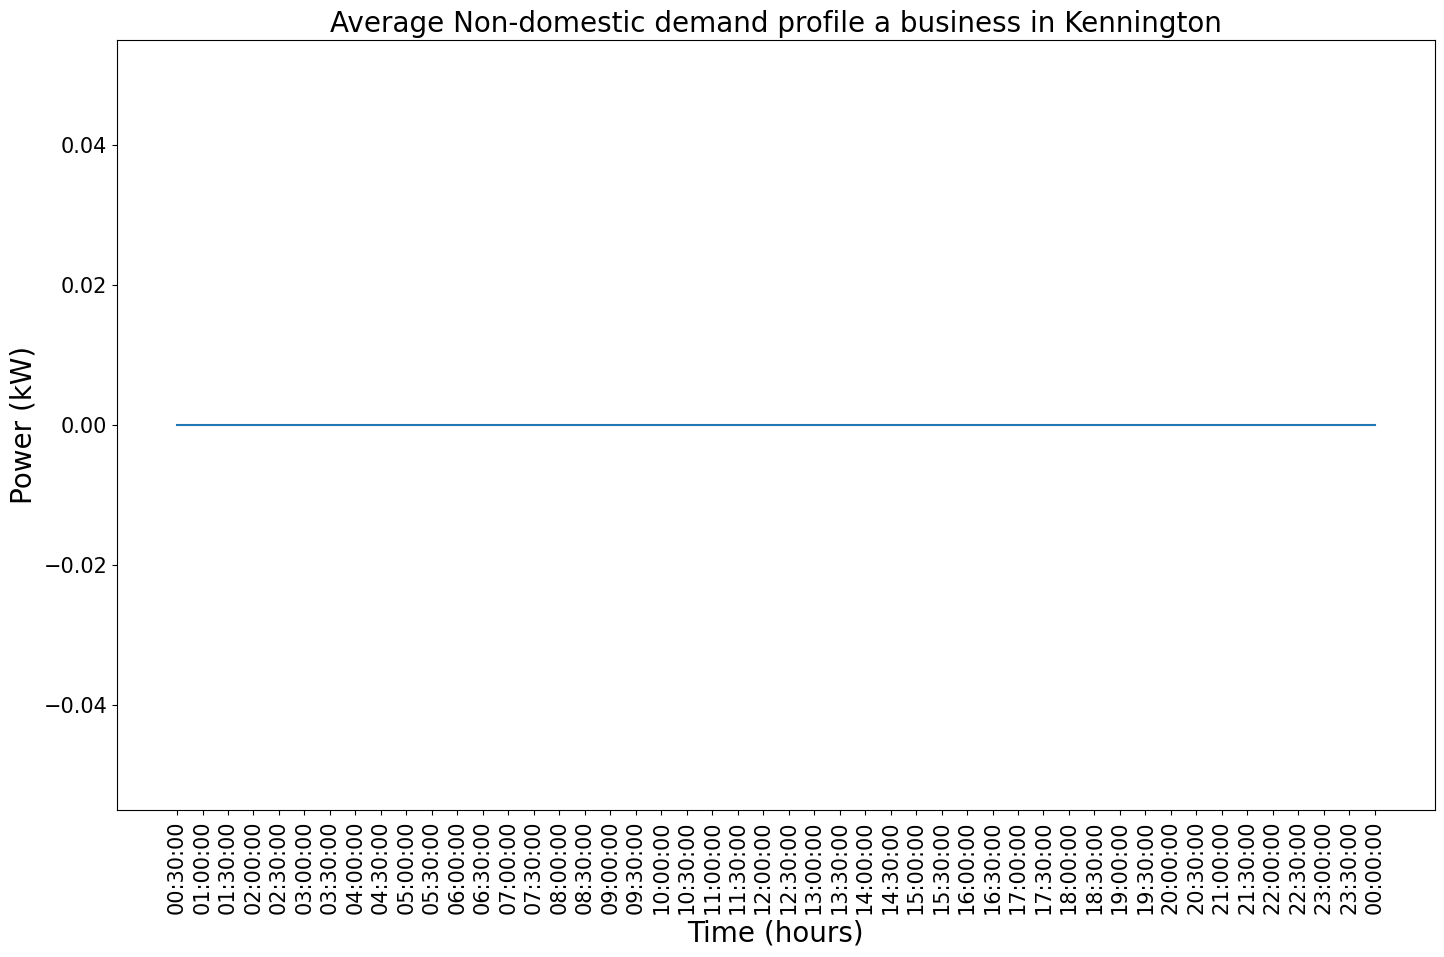

In [179]:
fig1, ax1 = plt.subplots(figsize=(17,10))

ax1.plot(non_dom_load_df['Time'].dt.strftime("%X"),x)
#ax1.plot(non_dom_load_df['Time'].dt.strftime("%H:%M"),x)


ax1.set(xlabel="Time (hours)",
    ylabel = "Power (kW)",
    title = 'Average Non-domestic demand profile a business in Kennington');

plt.xticks(rotation=90);

ax1.xaxis.label.set_size(20)
ax1.yaxis.label.set_size(20)
ax1.title.set_size(20)

ax1.tick_params(axis='both', which='major', labelsize=15)

## Plot annual demand

In [180]:
daily_mean = []

for i in range(365):
    #daily_mean(i) = mean(ken_avg_nd_load_profile[i*48:48*(i+1)])
    daily_mean = np.append(daily_mean,np.mean(corrected_ken_avg_nd_load_profile[i*48:48*(i+1)])) 
    
print(len(daily_mean))
#print(daily_mean)


365


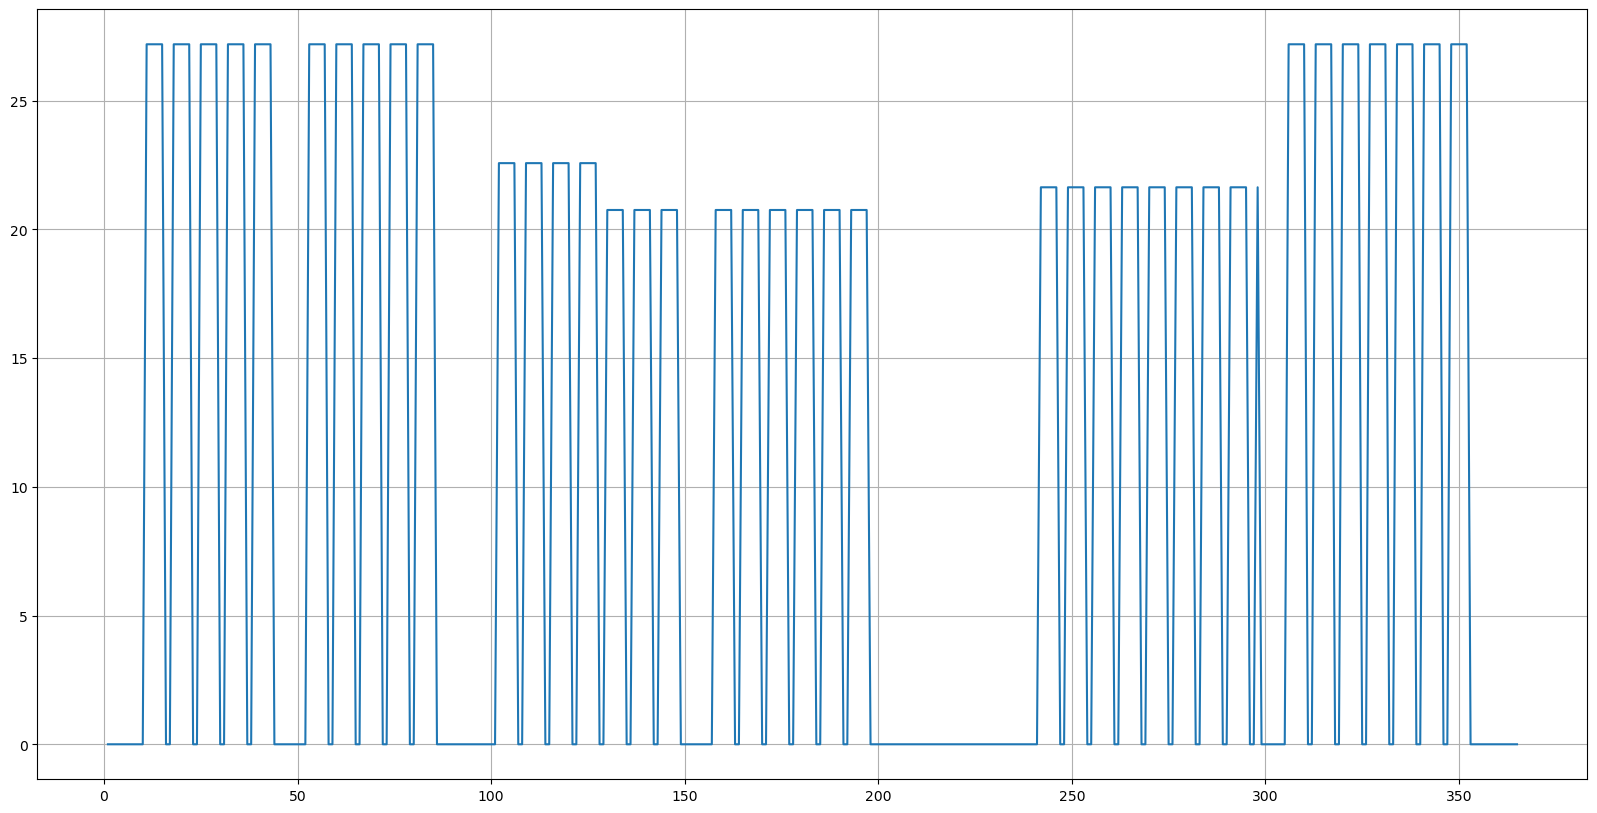

In [181]:
fig2, ax2 = plt.subplots(figsize=(20,10))
day = np.arange(1,366)
ax2.plot(day,daily_mean)
ax2.grid(b=True)


### Analysis of plot 

- winter = 22 weeks 
- spring = 6 weeks 
- summer = 10 weeks 
- high summer = 6 Weeks
- autumn = 8 weeks 

- The shape fits with the seasonal change - warmer seasons require less energy 
- the sharp dips at the end of each week are for sunday when lots of businesses are closed or have reduced opening hours (eg small shops, engineering works, town halls etc)

#### DAILY MEANS:

- winter weekday = 2.383
- winter sat = 1.629
- winter sun = 1.0929
- 49% diff between sat and sun 

- summer weekday = 1.8195
- summer sat = 1.377
- summer sun = 0.8955
- 32% diff between sat and sun 


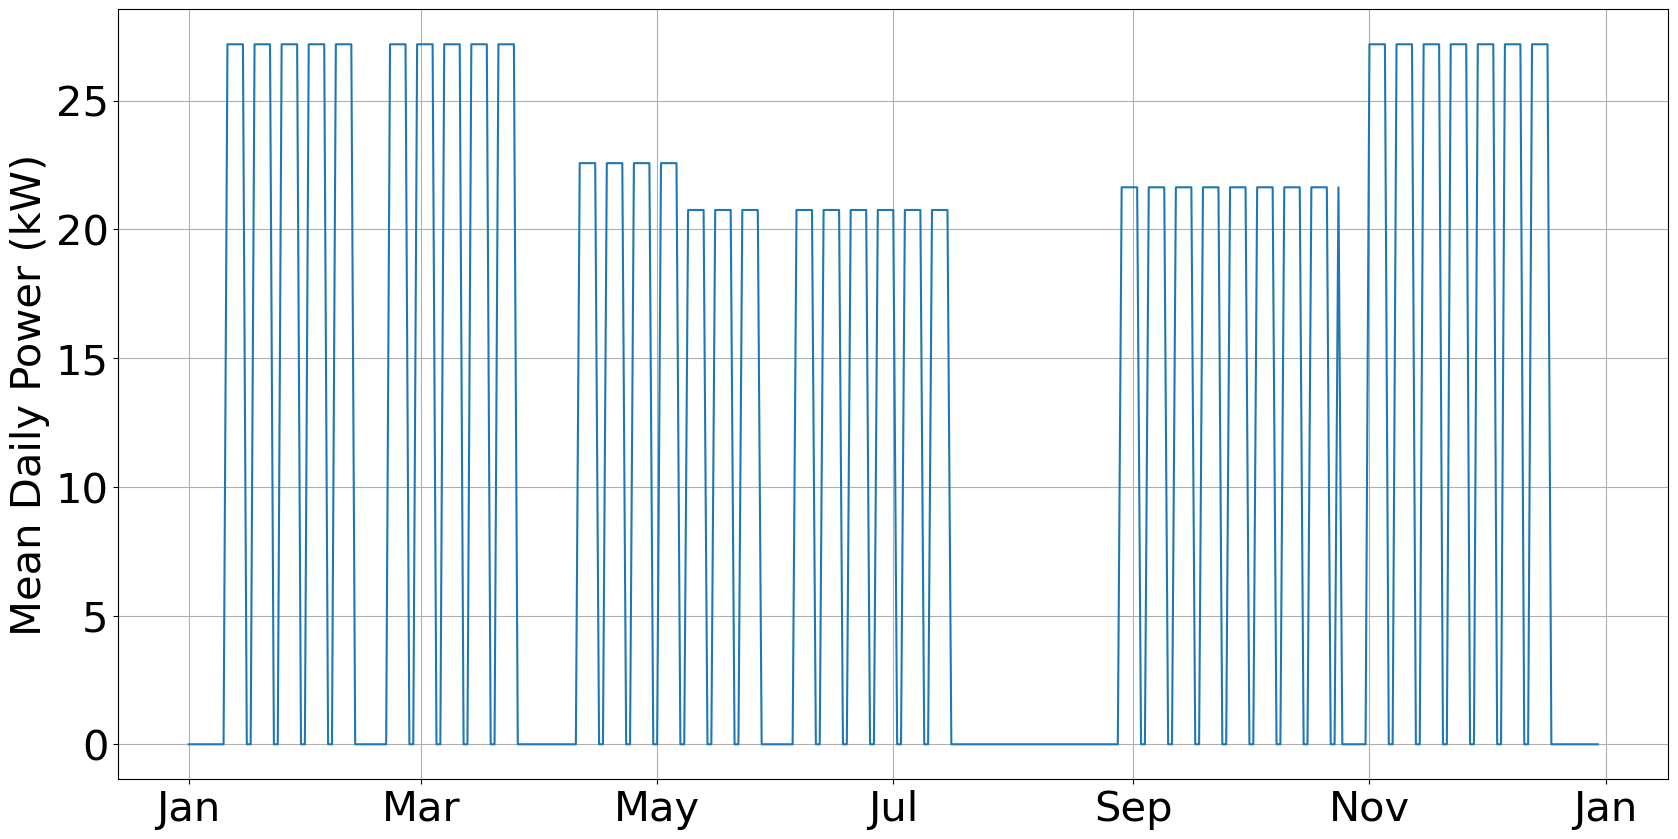

In [182]:
#### MORE ASTHETIC VERSION OF THE PLOT ABOVE - WITH BETTER X AXIS 
plt.style.use('default')                    # style of plot 
fig2, ax2 = plt.subplots(figsize=(20,10))   # size of figure window

#plt.xticks(rotation=90)                    # makes x-axis labels lie 90º to axis 
#plt.gcf().autofmt_xdate()                  # automatic rotation of the x-labels to angle that makes them fit       
#fig2.tight_layout(pad=3.0)                 # sets spacing between sub plots

#create datatime array to be x-axis ~ here the freq is set as D for days 
x_axis = pd.date_range(start='01/01/2020', periods = 365, freq= 'D')  

# choose the format you want the labels on x-axis to appea r as. Here %b gives abbrev month names
myFmt = mdates.DateFormatter('%b')          # format chosen 
ax2.xaxis.set_major_formatter(myFmt)        # the chosen format applied to the axis 

ax2.plot(x_axis,daily_mean)                 # actual PLOT command ~ x-axis array must be same length as daily_mean

# axis labels 
ax2.set_ylabel('Mean Daily Power (kW)')
#ax2.set_xlabel('Date')
#ax2.set_title('Domestic Demand Data for Kennington')
# axis label sizes set 
ax2.xaxis.label.set_size(30)
ax2.yaxis.label.set_size(30)
ax2.title.set_size(30)
# set size of numbers on axis 
ax2.tick_params(axis='both', which='major', labelsize=30)   
ax2.grid(b=True)    # adds grid to plot


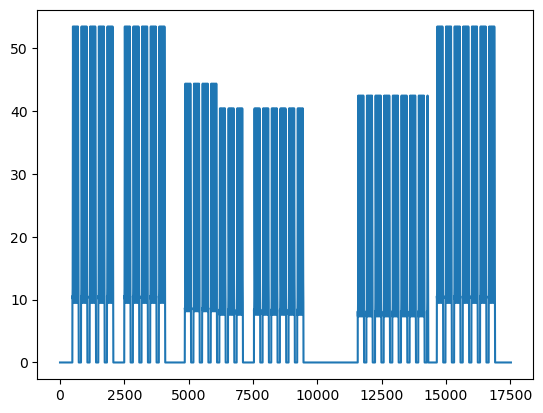

In [183]:
plt.plot(corrected_ken_avg_nd_load_profile)

# MAKE MORE ASTHETIC PLOT FOR REPORT:

To generate the various plots turn days:

= 0 for winter weekday 
= 1 for winter sat
= 2 for winter sun 


= 148 for summer weekday
= 149 for summer sat 
= 150 for summmer sun 

In [184]:
## ADD OWN DATE COLUMN TO DATA SET
ken_nd_df['Time'] = pd.date_range(start='1/1/2020', periods = len(ken_nd_df), freq='0.5H')

#print(ken_nd_df.head())
#print(ken_nd_df.info())

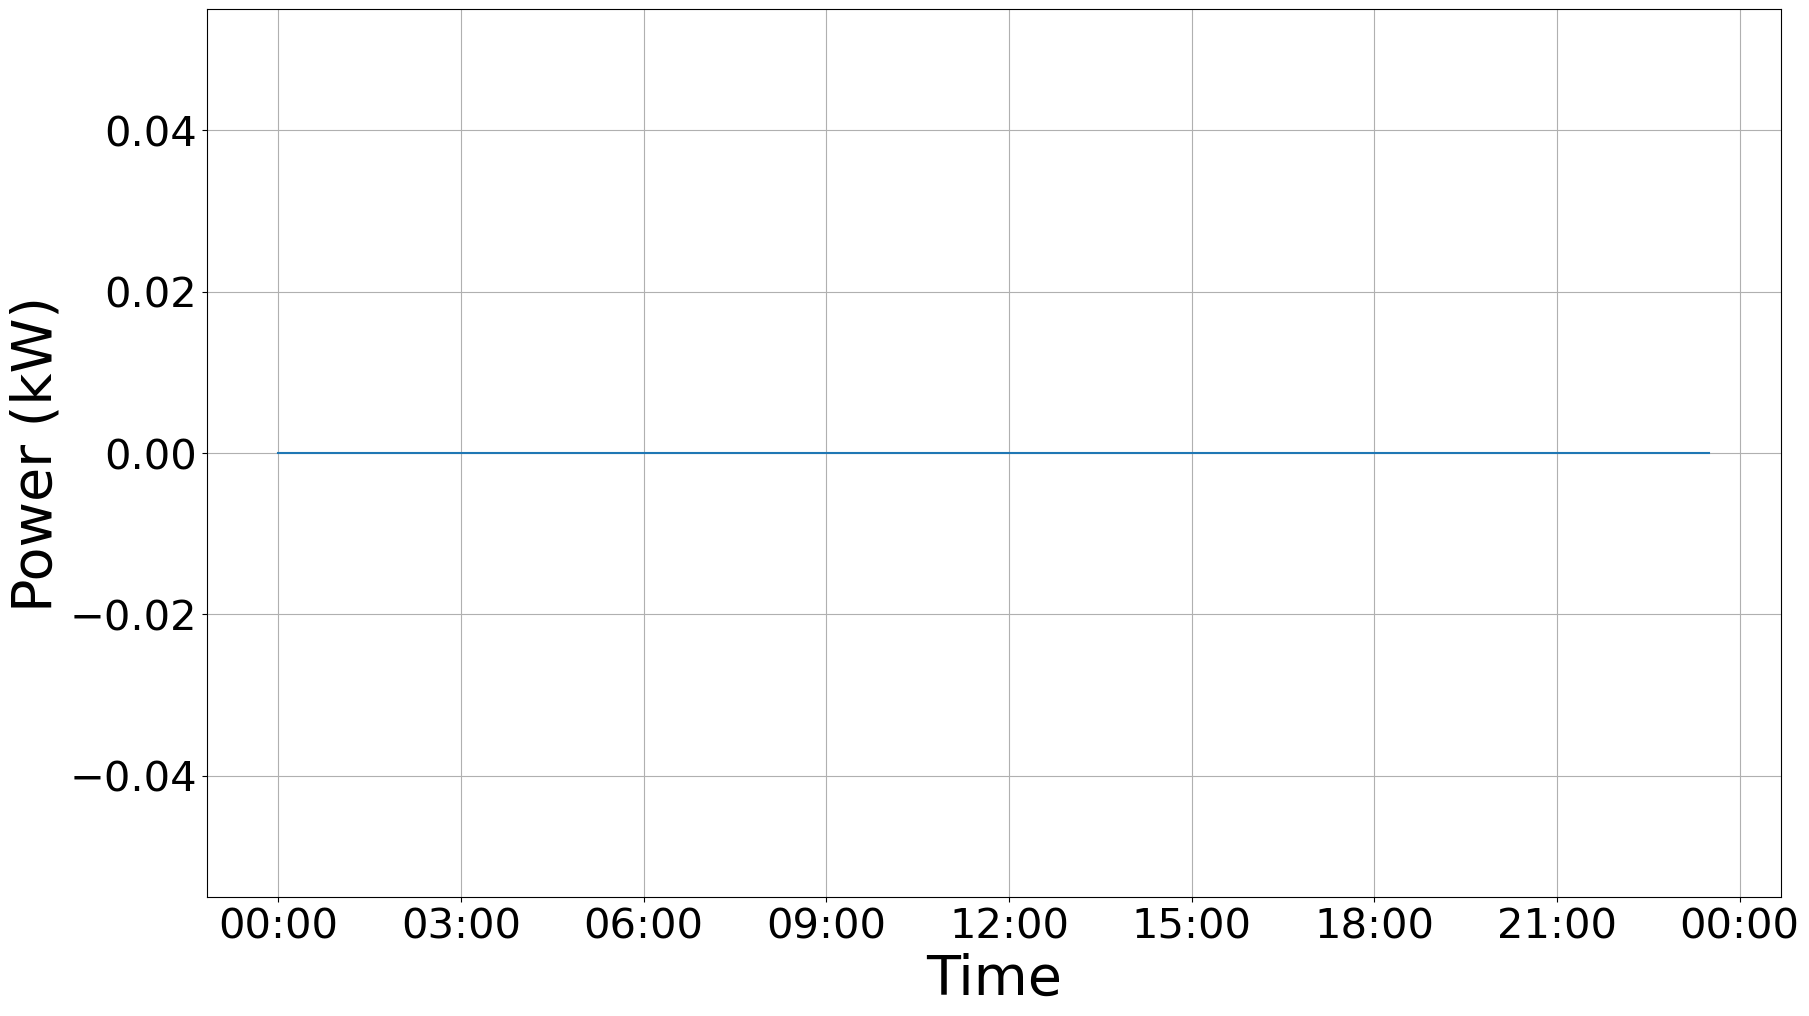

In [185]:
plt.style.use('default')
fig2, ax2 = plt.subplots(figsize=(17,10))
#ax.plot(EV_df[:,0],EV_df[:,1])

fig2.tight_layout(pad=3.0)

#x_axis = pd.date_range('2020' + '-06-06', periods = 48, freq= '0.5H') 
myFmt = mdates.DateFormatter('%H:%M')       # format the times into Hour:Minute format
#plt.gcf().autofmt_xdate()                   # automatic rotation of the axis plots
   

day = 0    # assume the days of year start with 1st Jan numbered as 0 

ax2.plot(ken_nd_df['Time'][day*48:(day+1)*48],ken_nd_df['Power (kW)'][day*48:(day+1)*48])

ax2.set_ylabel('Power (kW)')
ax2.set_xlabel('Time')
#ax2.set_title('Domestic Demand - Winter Weekday (6th Jan)')
ax2.xaxis.set_major_formatter(myFmt)   # apply HH:MM format to the x axis data
ax2.grid(b=True)

ax2.xaxis.label.set_size(40)
ax2.yaxis.label.set_size(40)
ax2.title.set_size(40)

ax2.tick_params(axis='both', which='major', labelsize=30)

**NOTE:**
This plot above is showing zero cos it's currently displaying the profile of 1st Jan 2020 whcih is a school holiday hence the demand is set as zero all day. 